In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
%matplotlib inline

In [2]:
df=pd.read_csv('listings.csv')

In [3]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [4]:
for i in df.columns:
    print(f"{i:<32}" +' %  Nulls: ' + f"{str(int((df[i].isnull().sum()/len(df))*100)) : >10}")

id                               %  Nulls:          0
listing_url                      %  Nulls:          0
scrape_id                        %  Nulls:          0
last_scraped                     %  Nulls:          0
name                             %  Nulls:          0
summary                          %  Nulls:          4
space                            %  Nulls:         14
description                      %  Nulls:          0
experiences_offered              %  Nulls:          0
neighborhood_overview            %  Nulls:         27
notes                            %  Nulls:         42
transit                          %  Nulls:         24
thumbnail_url                    %  Nulls:          8
medium_url                       %  Nulls:          8
picture_url                      %  Nulls:          0
xl_picture_url                   %  Nulls:          8
host_id                          %  Nulls:          0
host_url                         %  Nulls:          0
host_name                   

In [5]:
df=df.drop(['listing_url','thumbnail_url','medium_url' , 'picture_url','xl_picture_url','scrape_id','last_scraped',
            'experiences_offered','picture_url','requires_license','license','jurisdiction_names','state','city','market'
            ,'smart_location','country_code','country','longitude','latitude','square_feet','has_availability',
            'calendar_last_scraped','host_url','host_name','host_location','host_about','host_thumbnail_url',
            'host_picture_url','street','availability_30','availability_60','availability_90','first_review',
            'last_review'],axis=1)

In [6]:
for i in df.columns:
    print(f"{i:<32}" +'  : '+ str(df[i].dtypes))

id                                : int64
name                              : object
summary                           : object
space                             : object
description                       : object
neighborhood_overview             : object
notes                             : object
transit                           : object
host_id                           : int64
host_since                        : object
host_response_time                : object
host_response_rate                : object
host_acceptance_rate              : object
host_is_superhost                 : object
host_neighbourhood                : object
host_listings_count               : float64
host_total_listings_count         : float64
host_verifications                : object
host_has_profile_pic              : object
host_identity_verified            : object
neighbourhood                     : object
neighbourhood_cleansed            : object
neighbourhood_group_cleansed      : object
zipcode    

In [7]:
df_sent1=df[['id','name','summary','space','description']]

In [8]:
cols=['notes','transit']

In [9]:
for i in cols:
    df[i]=df[i].str.len()

In [10]:
df.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,host_id,host_since,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,956883,2011-08-11,...,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",1000.0,162.0,5177328,2013-02-21,...,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,155.0,202.0,16708587,2014-06-12,...,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,NaN,NaN,NaN,9851441,2013-11-06,...,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,9.0,295.0,1452570,2011-11-29,...,10.0,10.0,9.0,9.0,f,strict,f,f,1,0.89


In [11]:
df_sent1=df_sent1.fillna('none')

In [12]:

def Analyze(df):
    def senti (phrase):
        sia = SentimentIntensityAnalyzer()        
        return sia.polarity_scores(phrase)['compound']
    
    object_df=df.select_dtypes(include=['object'])
    for i in object_df.columns:
        object_df[i]=object_df[i].apply(senti)
    
    return object_df          
analyzed_df=Analyze(df_sent1)
analyzed_df

<ipython-input-12-96168b7cfd7a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  object_df[i]=object_df[i].apply(senti)


,name,summary,space,description
0,0.0000,0.0000,0.8439,0.8439
1,0.4404,-0.6151,0.9958,0.9926
2,0.0000,0.7425,0.9360,0.9665
3,0.0000,0.6369,0.0000,0.6369
4,0.5859,0.8356,0.9077,0.9689
...,...,...,...,...
3813,0.0000,0.0000,0.9885,0.9850
3814,0.0000,0.5574,0.7003,0.5346
3815,0.0000,0.9121,0.0000,0.9121
3816,0.7644,0.8513,0.8960,0.9643


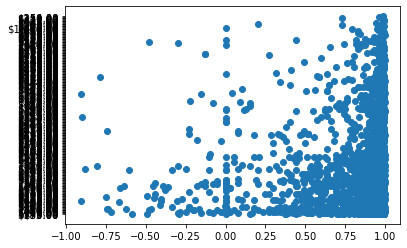

In [13]:
plt.scatter(x=analyzed_df['description'],y=df['price']);

In [14]:
analyzed_df['sum'] = analyzed_df.sum(axis=1)

In [15]:
analyzed_df

,name,summary,space,description,sum
0,0.0000,0.0000,0.8439,0.8439,1.6878
1,0.4404,-0.6151,0.9958,0.9926,1.8137
2,0.0000,0.7425,0.9360,0.9665,2.6450
3,0.0000,0.6369,0.0000,0.6369,1.2738
4,0.5859,0.8356,0.9077,0.9689,3.2981
...,...,...,...,...,...
3813,0.0000,0.0000,0.9885,0.9850,1.9735
3814,0.0000,0.5574,0.7003,0.5346,1.7923
3815,0.0000,0.9121,0.0000,0.9121,1.8242
3816,0.7644,0.8513,0.8960,0.9643,3.4760


In [17]:
df1= df[['id', 'number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication','review_scores_value']]
df1.fillna(0,inplace=True)

df1['review_scores_total']=df1['review_scores_rating']+df1['review_scores_accuracy']+df1['review_scores_cleanliness']+df1.review_scores_checkin
+df1.review_scores_communication+df1.review_scores_value;

C:\Users\ajax2\anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-17-c7a56fc27881>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['review_scores_total']=df1['review_scores_rating']+df1['review_scores_accuracy']+df1['review_scores_cleanliness']+df1.review_scores_checkin


In [18]:
df=df.drop(['name','summary','space','description','notes','transit','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication','review_scores_value','neighborhood_overview'],axis=1)

In [19]:
df2=df[['amenities']]
df2['amenities']=(df2['amenities']).str.replace('"','')
df2['amenities']=(df2['amenities']).str.strip('/\{}')
df2=df2['amenities'].str.split(',',expand=True)

df3=pd.concat([df['id'],df2],axis=1)
df3['amenities_count']=df3.apply(lambda x: x.count(), axis=1)
df3

<ipython-input-19-e0950d17a815>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['amenities']=(df2['amenities']).str.replace('"','')
<ipython-input-19-e0950d17a815>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['amenities']=(df2['amenities']).str.strip('/\{}')


,id,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,amenities_count
0,241032,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Kitchen,Heating,Family/Kid Friendly,Washer,...,None,None,None,None,None,None,None,None,None,11
1,953595,TV,Internet,Wireless Internet,Kitchen,Free Parking on Premises,Buzzer/Wireless Intercom,Heating,Family/Kid Friendly,Washer,...,None,None,None,None,None,None,None,None,None,17
2,3308979,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Kitchen,Free Parking on Premises,Pets Allowed,Pets live on this property,...,None,None,None,None,None,None,None,None,None,22
3,7421966,Internet,Wireless Internet,Kitchen,Indoor Fireplace,Heating,Family/Kid Friendly,Washer,Dryer,Smoke Detector,...,None,None,None,None,None,None,None,None,None,15
4,278830,TV,Cable TV,Internet,Wireless Internet,Kitchen,Heating,Family/Kid Friendly,Smoke Detector,Carbon Monoxide Detector,...,None,None,None,None,None,None,None,None,None,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Wheelchair Accessible,Kitchen,Free Parking on Premises,Heating,...,None,None,None,None,None,None,None,None,None,17
3814,8902327,TV,Cable TV,Internet,Wireless Internet,Kitchen,Free Parking on Premises,Heating,Family/Kid Friendly,Smoke Detector,...,None,None,None,None,None,None,None,None,None,18
3815,10267360,Cable TV,Wireless Internet,Kitchen,Free Parking on Premises,Breakfast,Pets live on this property,Dog(s),Cat(s),Heating,...,None,None,None,None,None,None,None,None,None,21
3816,9604740,TV,Wireless Internet,Kitchen,Free Parking on Premises,Elevator in Building,Heating,Smoke Detector,Essentials,Hangers,...,None,None,None,None,None,None,None,None,None,12


col_0,% observations
host_since,
2008-11-10,0.001048
2009-01-08,0.000262
2009-02-16,0.000524
2009-03-03,0.000262
2009-03-30,0.000262
...,...
2015-12-29,0.000262
2015-12-30,0.000262
2016-01-01,0.000262


# of unique values 1380


col_0,% observations
host_response_time,
a few days or more,0.011533
within a day,0.181184
within a few hours,0.293778
within an hour,0.513505


# of unique values 4


col_0,% observations
host_response_rate,
100%,0.719575
17%,0.000607
25%,0.000910
30%,0.000303
31%,0.000303
33%,0.004249
38%,0.000303
40%,0.003642
43%,0.001214


# of unique values 45


col_0,% observations
host_acceptance_rate,
0%,0.000328
100%,0.999672


# of unique values 2


col_0,% observations
host_is_superhost,
f,0.796122
t,0.203878


# of unique values 2


col_0,% observations
host_neighbourhood,
Alki,0.006254
Anaheim,0.001990
Arbor Heights,0.000853
Atlantic,0.013928
Baldwin Hills,0.000284
...,...
Wallingford,0.038090
Wedgewood,0.004548
Westlake,0.003411


# of unique values 102


col_0,% observations
host_verifications,
None,0.000524
"['email', 'facebook', 'google', 'linkedin', 'reviews', 'kba']",0.000262
"['email', 'facebook', 'reviews', 'jumio']",0.000786
"['email', 'facebook', 'reviews', 'kba']",0.000262
"['email', 'facebook', 'reviews']",0.000786
...,...
"['phone', 'reviews', 'kba']",0.000524
"['phone', 'reviews']",0.007858
['phone'],0.005238


# of unique values 116


col_0,% observations
host_has_profile_pic,
f,0.001834
t,0.998166


# of unique values 2


col_0,% observations
host_identity_verified,
f,0.214623
t,0.785377


# of unique values 2


col_0,% observations
neighbourhood,
Alki,0.006761
Arbor Heights,0.000882
Atlantic,0.014697
Ballard,0.062610
Belltown,0.059965
...,...
Wallingford,0.042034
Wedgewood,0.004409
Westlake,0.003527


# of unique values 81


col_0,% observations
neighbourhood_cleansed,
Adams,0.018334
Alki,0.011001
Arbor Heights,0.001310
Atlantic,0.013882
Belltown,0.061289
...,...
West Woodland,0.016763
Westlake,0.004453
Whittier Heights,0.006810


# of unique values 87


col_0,% observations
neighbourhood_group_cleansed,
Ballard,0.060241
Beacon Hill,0.030906
Capitol Hill,0.148507
Cascade,0.023311
Central Area,0.096647
Delridge,0.020691
Downtown,0.138816
Interbay,0.002881
Lake City,0.017548


# of unique values 17


col_0,% observations
zipcode,
98101,0.052742
98102,0.088953
98103,0.103385
98104,0.024928
98105,0.059040
98106,0.015219
98107,0.047232
98108,0.014694
98109,0.053004


# of unique values 28


col_0,% observations
is_location_exact,
f,0.106338
t,0.893662


# of unique values 2


col_0,% observations
property_type,
Apartment,0.447472
Bed & Breakfast,0.009693
Boat,0.002096
Bungalow,0.003406
Cabin,0.005502
Camper/RV,0.003406
Chalet,0.000524
Condominium,0.023841
Dorm,0.000524


# of unique values 16


col_0,% observations
room_type,
Entire home/apt,0.665532
Private room,0.303824
Shared room,0.030644


# of unique values 3


col_0,% observations
bed_type,
Airbed,0.007072
Couch,0.003405
Futon,0.019382
Pull-out Sofa,0.012310
Real Bed,0.957831


# of unique values 5


col_0,% observations
amenities,
"{""Air Conditioning"",Kitchen,""Free Parking on Premises"",""Pets Allowed"",Heating,Washer,Dryer,""Smoke Detector"",Essentials,Shampoo,""Lock on Bedroom Door"",Hangers}",0.000262
"{""Cable TV"",""Elevator in Building"",Heating,Washer,Dryer}",0.000262
"{""Cable TV"",""Wireless Internet"",""Air Conditioning"",""Free Parking on Premises"",Breakfast,""Pets live on this property"",Dog(s),""Indoor Fireplace"",Heating,Washer,Dryer,""Smoke Detector"",""Carbon Monoxide Detector"",""Fire Extinguisher"",Essentials,Shampoo}",0.000262
"{""Cable TV"",""Wireless Internet"",""Air Conditioning"",""Wheelchair Accessible"",Kitchen,""Free Parking on Premises"",""Pets Allowed"",Heating,""Family/Kid Friendly"",Washer,Dryer,""Smoke Detector"",""Carbon Monoxide Detector"",""First Aid Kit"",""Fire Extinguisher"",Essentials,""24-Hour Check-in"",Hangers,Iron,""Laptop Friendly Workspace""}",0.000262
"{""Cable TV"",""Wireless Internet"",""Air Conditioning"",Breakfast,""Pets live on this property"",Cat(s),Heating,""Smoke Detector"",""First Aid Kit"",Essentials,Shampoo,Hangers,""Hair Dryer""}",0.000262
...,...
"{TV,Kitchen,Heating,Washer,Dryer,""Smoke Detector"",""Carbon Monoxide Detector"",Essentials,Shampoo}",0.000262
"{TV,Pool,Kitchen,""Elevator in Building"",""Buzzer/Wireless Intercom"",Heating,Washer,Dryer,Essentials,Shampoo}",0.000262
"{TV,Pool,Kitchen,""Pets Allowed"",Gym,""Pets live on this property"",Dog(s),Cat(s),""Elevator in Building"",""Hot Tub"",""Indoor Fireplace"",Heating,""Family/Kid Friendly"",Washer,Dryer,Essentials,Hangers,Iron,""Laptop Friendly Workspace""}",0.000262


# of unique values 3284


col_0,% observations
price,
$100.00,0.041645
$1000.00,0.000262
$101.00,0.000262
$102.00,0.000262
$103.00,0.001833
...,...
$97.00,0.003929
$975.00,0.000262
$98.00,0.004191


# of unique values 273


col_0,% observations
weekly_price,
"$1,000.00",0.034843
"$1,005.00",0.000498
"$1,008.00",0.001493
"$1,009.00",0.000498
"$1,015.00",0.000498
...,...
$985.00,0.000498
$990.00,0.002987
$993.00,0.000498


# of unique values 395


col_0,% observations
monthly_price,
"$1,000.00",0.011206
"$1,005.00",0.000659
"$1,020.00",0.000659
"$1,029.00",0.001318
"$1,050.00",0.003296
...,...
$975.00,0.000659
$985.00,0.001318
$987.00,0.000659


# of unique values 356


col_0,% observations
security_deposit,
"$1,000.00",0.015541
"$1,200.00",0.001072
"$1,500.00",0.005895
"$1,900.00",0.000536
$100.00,0.186495
$109.00,0.000536
$115.00,0.000536
$120.00,0.001608
$125.00,0.006431


# of unique values 46


col_0,% observations
cleaning_fee,
$10.00,0.055237
$100.00,0.060976
$101.00,0.001076
$105.00,0.002869
$106.00,0.000359
...,...
$90.00,0.011478
$95.00,0.013989
$96.00,0.004663


# of unique values 118


col_0,% observations
extra_people,
$0.00,0.536406
$10.00,0.092981
$100.00,0.004191
$12.00,0.002095
$13.00,0.000262
$14.00,0.001048
$15.00,0.080932
$16.00,0.000262
$17.00,0.001572


# of unique values 45


col_0,% observations
calendar_updated,
1 week ago,0.006810
10 months ago,0.002095
11 months ago,0.001310
12 months ago,0.001310
13 months ago,0.000524
14 months ago,0.000262
15 months ago,0.000262
16 months ago,0.000262
17 months ago,0.000262


# of unique values 34


col_0,% observations
instant_bookable,
f,0.845207
t,0.154793


# of unique values 2


col_0,% observations
cancellation_policy,
flexible,0.301205
moderate,0.327658
strict,0.371137


# of unique values 3


col_0,% observations
require_guest_profile_picture,
f,0.915925
t,0.084075


# of unique values 2


col_0,% observations
require_guest_phone_verification,
f,0.901781
t,0.098219


# of unique values 2


,id,host_id,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_365,review_scores_location,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3802.000000,3812.000000,3817.000000,3818.000000,3818.000000,3818.000000,3818.000000,3163.000000,3818.000000,3191.000000
mean,5.550111e+06,1.578556e+07,7.157757,7.157757,3.349398,1.259469,1.307712,1.735394,1.672603,2.369303,780.447617,244.772656,9.608916,2.946307,2.078919
std,2.962660e+06,1.458382e+07,28.628149,28.628149,1.977599,0.590369,0.883395,1.139480,1.311040,16.305902,1683.589007,126.772526,0.629053,5.893029,1.822348
min,3.335000e+03,4.193000e+03,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,4.000000,1.000000,0.020000
25%,3.258256e+06,3.275204e+06,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,60.000000,124.000000,9.000000,1.000000,0.695000
50%,6.118244e+06,1.055814e+07,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1125.000000,308.000000,10.000000,1.000000,1.540000
75%,8.035127e+06,2.590309e+07,3.000000,3.000000,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1125.000000,360.000000,10.000000,2.000000,3.000000
max,1.034016e+07,5.320861e+07,502.000000,502.000000,16.000000,8.000000,7.000000,15.000000,15.000000,1000.000000,100000.000000,365.000000,10.000000,37.000000,12.150000


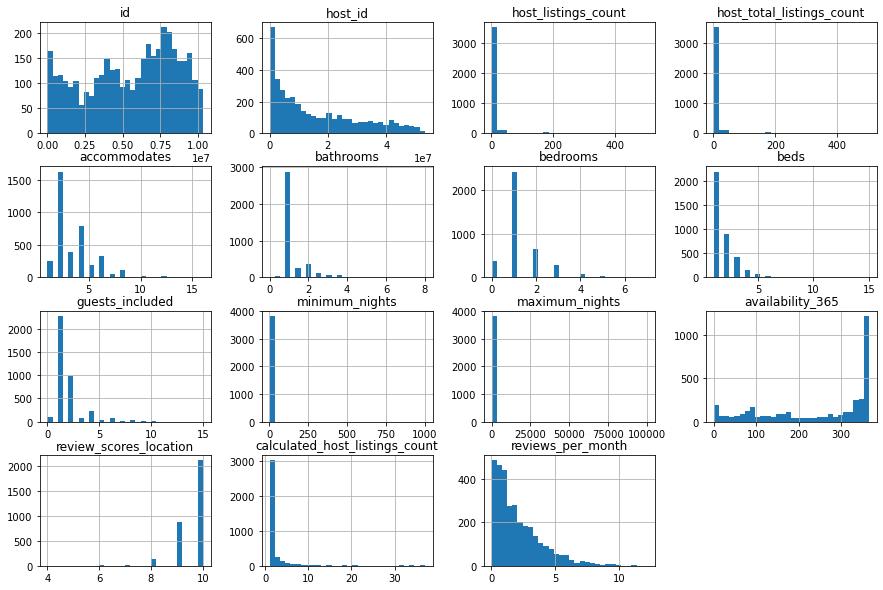

In [21]:
for column in df.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=df[column],
                        columns='% observations', 
                        normalize='columns'))
    print("# of unique values {}".format(df[column].nunique()))

# show summary statistics
display(df.describe())

# build histograms for each numeric feature
%matplotlib inline
hist = df.hist(bins=30, sharey=False, figsize=(15, 10))

In [22]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'availability_365', 'review_scores_location',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

In [23]:
host_ver_df=df[['host_verifications']]

In [24]:
df_dummies=df[['host_response_time','host_is_superhost','host_identity_verified','neighbourhood_group_cleansed','zipcode',
      'is_location_exact','property_type','room_type','bed_type','instant_bookable','cancellation_policy',
       'require_guest_profile_picture','require_guest_phone_verification']]

In [25]:
def numeric_converter(df):
    for i in df.columns:
        df[i]=df[i].str.strip('% $ ,')
        df[i]=df[i].str.replace(',', '')
        df[i]=pd.to_numeric(df[i],downcast='float')
    return df

In [26]:
df[['host_response_rate','price','security_deposit','cleaning_fee','extra_people']]=numeric_converter(df[['host_response_rate','price','security_deposit','cleaning_fee','extra_people']])

<ipython-input-25-bd7e4a38af9c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=df[i].str.strip('% $ ,')
<ipython-input-25-bd7e4a38af9c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=df[i].str.replace(',', '')
<ipython-input-25-bd7e4a38af9c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [28]:
df_numeric=df.select_dtypes(include=['int64','float64',])

df_numeric

,id,host_id,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_365,review_scores_location,calculated_host_listings_count,reviews_per_month
0,241032,956883,3.0,3.0,4,1.0,1.0,1.0,2,1,365,346,9.0,2,4.07
1,953595,5177328,6.0,6.0,4,1.0,1.0,1.0,1,2,90,291,10.0,6,1.48
2,3308979,16708587,2.0,2.0,11,4.5,5.0,7.0,10,4,30,220,10.0,2,1.15
3,7421966,9851441,1.0,1.0,3,1.0,0.0,2.0,1,1,1125,143,NaN,1,NaN
4,278830,1452570,2.0,2.0,6,2.0,3.0,3.0,6,1,1125,365,9.0,1,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,31148752,354.0,354.0,6,2.0,3.0,3.0,1,3,1125,32,10.0,8,0.30
3814,8902327,46566046,1.0,1.0,4,1.0,1.0,2.0,3,2,29,273,10.0,1,2.00
3815,10267360,52791370,1.0,1.0,2,1.0,1.0,1.0,2,1,7,88,NaN,1,NaN
3816,9604740,25522052,1.0,1.0,2,1.0,0.0,1.0,1,3,1125,179,NaN,1,NaN


In [29]:
df=df.drop(['host_since','host_acceptance_rate','host_neighbourhood','host_has_profile_pic','neighbourhood_cleansed',
      'neighbourhood','weekly_price','monthly_price','calendar_updated','minimum_nights','maximum_nights','extra_people'],axis=1)

In [ ]:
df.extra_people.value_counts()

In [30]:
df.shape[1]-df_dummies.shape[1]-df_numeric.shape[1]

4

In [ ]:
df_dummies

In [ ]:
df.columns

In [ ]:
df_numeric.columns

In [ ]:
df_dummies.columns

In [ ]:
def str_split(df,col):
    
    df[col]=df[col].str.replace('"','')
    df[col]=df[col].str.strip(" []''")
    df=df[col].str.split(',',expand=True)
    
    return df

def row_count(df):    
    df['count']=df.apply(lambda x: x.count(), axis=1)
    return df

In [ ]:
df['host_verifications']=row_count(str_split(host_ver_df,'host_verifications'))[:]['count']

In [ ]:
df.head()